In [1]:
from typing import Dict, Tuple, List

import torch
import torch.nn as nn
import numpy as np
from random import randint
from scipy.io import loadmat
import matplotlib
import sys

sys.path.append('/garmentor')

from configs import paths

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    PerspectiveCameras,
    OrthographicCameras,
    PointLights,
    RasterizationSettings,
    MeshRasterizer,
    HardPhongShader,
    TexturesUV,
    TexturesVertex,
    BlendParams,
    Textures)

from configs.poseMF_shapeGaussian_net_config import get_cfg_defaults
from models.parametric_model import ParametricModel
from configs.poseMF_shapeGaussian_net_config import get_cfg_defaults
from utils.augmentation.smpl_augmentation import (
    normal_sample_shape_numpy,
    normal_sample_style_numpy
)
from utils.augmentation.cam_augmentation import augment_cam_t_numpy
from utils.garment_classes import GarmentClasses
from utils.colors import NoColors, GarmentColors, BodyColors, N
from utils.mesh_utils import concatenate_meshes
from renderers.surreal_renderer import SurrealRenderer

from tailornet_for_garmentor.models.smpl4garment_utils import SMPL4GarmentOutput


In [2]:
def _load_poses() -> np.ndarray:
    '''Load poses. Adapted from the original HierProb3D code.'''
    data = np.load(paths.TRAIN_POSES_PATH)
    fnames = data['fnames']
    poses = data['poses']
    indices = [i for i, x in enumerate(fnames)
                if (x.startswith('h36m') or x.startswith('up3d') or x.startswith('3dpw'))]
    return np.stack([poses[i] for i in indices], axis=0)


cfg = get_cfg_defaults()

x_axis = np.array([1., 0., 0.], dtype=np.float32)
delta_betas_std_vector = np.ones(
    cfg.MODEL.NUM_SMPL_BETAS, 
    dtype=np.float32) * \
        cfg.TRAIN.SYNTH_DATA.AUGMENT.SMPL.SHAPE_STD
mean_shape = np.zeros(
    cfg.MODEL.NUM_SMPL_BETAS, 
    dtype=np.float32)
delta_style_std_vector = np.ones(
    cfg.MODEL.NUM_STYLE_PARAMS, 
    dtype=np.float32) * \
        cfg.TRAIN.SYNTH_DATA.AUGMENT.GARMENTOR.STYLE_STD
mean_style = np.zeros(
    cfg.MODEL.NUM_STYLE_PARAMS, 
    dtype=np.float32)
mean_cam_t = np.array(
    cfg.TRAIN.SYNTH_DATA.MEAN_CAM_T, 
    dtype=np.float32)

In [3]:
poses = _load_poses()

In [4]:
gender = 'male'
upper_class = 't-shirt'
lower_class = 'pant'

pose = poses[0]

shape: np.ndarray = normal_sample_shape_numpy(
    mean_params=mean_shape,
    std_vector=delta_betas_std_vector)

cam_t: np.ndarray = augment_cam_t_numpy(
    mean_cam_t,
    xy_std=cfg.TRAIN.SYNTH_DATA.AUGMENT.CAM.XY_STD,
    delta_z_range=cfg.TRAIN.SYNTH_DATA.AUGMENT.CAM.DELTA_Z_RANGE)
    
style_vector: np.ndarray = normal_sample_style_numpy(
            num_garment_classes=GarmentClasses.NUM_CLASSES,
            mean_params=mean_style,
            std_vector=delta_style_std_vector)
    
garment_classes = GarmentClasses(upper_class, lower_class)

parametric_model = ParametricModel(
                        gender=gender, 
                        garment_classes=garment_classes
                    )

Initializing (male, t-shirt, pant) model...
USING LF LOG DIR:  /data/tailornet/weights/t-shirt_male_weights/tn_orig_lf/t-shirt_male
USING HF LOG DIR:  /data/tailornet/weights/t-shirt_male_weights/tn_orig_hf/t-shirt_male
USING SS2G LOG DIR:  /data/tailornet/weights/t-shirt_male_weights/tn_orig_ss2g/t-shirt_male
loading /data/tailornet/weights/t-shirt_male_weights/tn_orig_hf/t-shirt_male/008_000/lin.pth.tar
loading /data/tailornet/weights/t-shirt_male_weights/tn_orig_hf/t-shirt_male/006_023/lin.pth.tar
loading /data/tailornet/weights/t-shirt_male_weights/tn_orig_hf/t-shirt_male/008_002/lin.pth.tar
loading /data/tailornet/weights/t-shirt_male_weights/tn_orig_hf/t-shirt_male/006_016/lin.pth.tar
loading /data/tailornet/weights/t-shirt_male_weights/tn_orig_hf/t-shirt_male/007_018/lin.pth.tar
loading /data/tailornet/weights/t-shirt_male_weights/tn_orig_hf/t-shirt_male/008_009/lin.pth.tar
loading /data/tailornet/weights/t-shirt_male_weights/tn_orig_hf/t-shirt_male/008_007/lin.pth.tar
loading /

In [6]:
style_vector = -np.ones((4,4)) * 1.5

smpl_output_dict = parametric_model.run(
            pose=pose,
            shape=shape,
            style_vector=style_vector
        )
device = 'cuda:0'


renderer = SurrealRenderer(device=device, batch_size=1)

rgb, seg_maps = renderer(smpl_output_dict=smpl_output_dict,
                         garment_classes=garment_classes)

Running TailorNet (upper -> t-shirt(label=0))...
Running SMPL4Garment (t-shirt)...
Running TailorNet (lower -> pant(label=3))...
Running SMPL4Garment (pant)...

Renderer projection type: perspective


5
(256, 256)


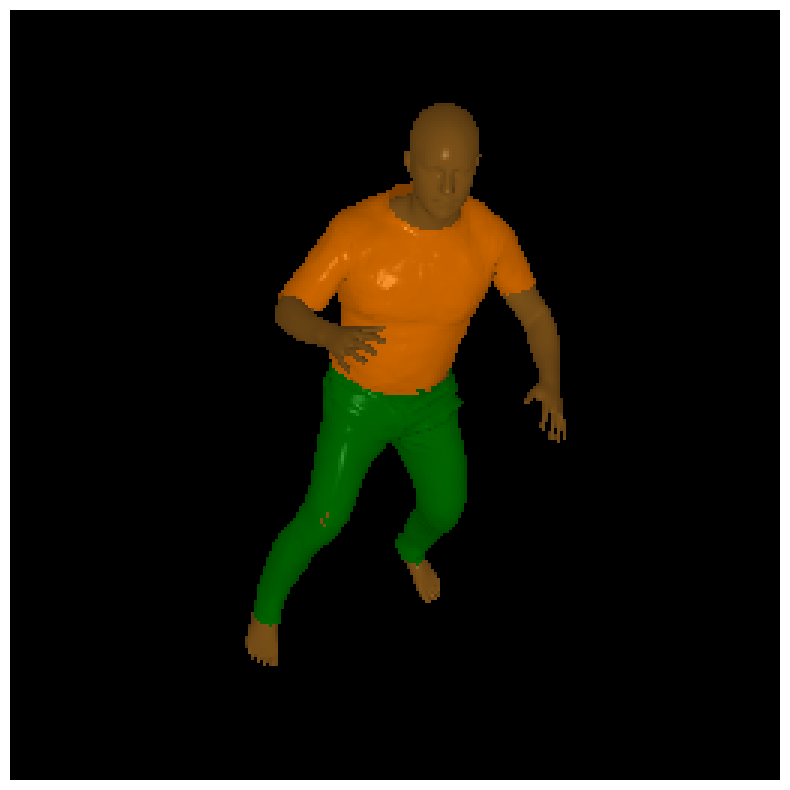

In [7]:
import matplotlib.pyplot as plt

img = rgb
print(len(seg_maps))
print(seg_maps[0].shape)
#img = seg_maps[0].cpu().numpy().astype(np.float32)

plt.figure(figsize=(10, 10))
plt.imshow(img[..., :3])
plt.axis("off");

5
(5, 256, 256)
[0. 1.]
(256, 256)
0.0


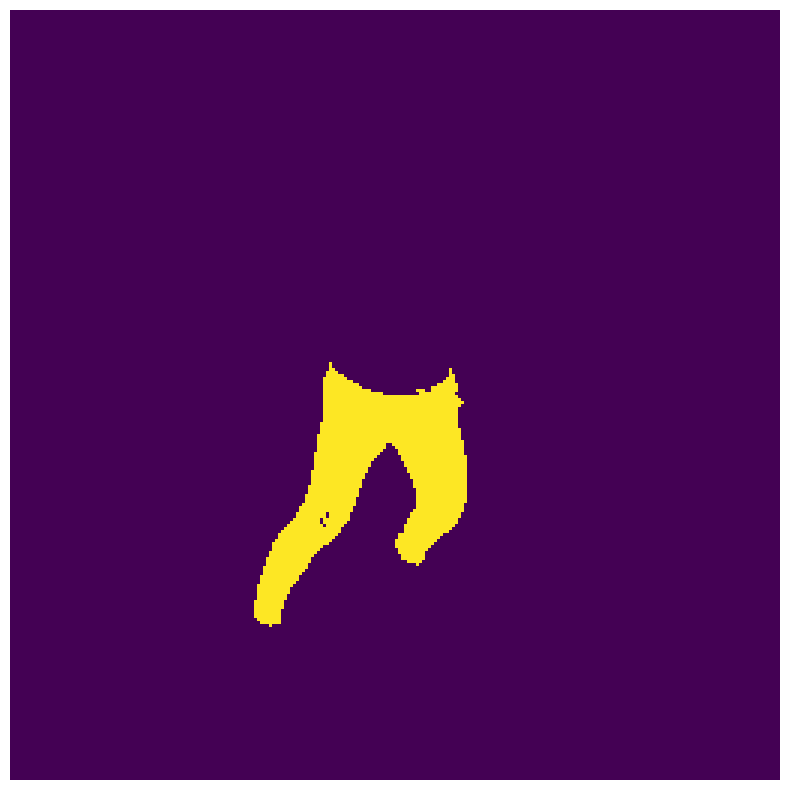

In [8]:
print(len(seg_maps))
print(seg_maps.shape)
#print(seg_maps[0])
seg = seg_maps[3].astype(np.float32)

print(np.unique(seg))
print(seg.shape)
print(seg[0, 0])

plt.figure(figsize=(10, 10))
plt.imshow(seg)
plt.axis("off");

## Test segmentation maps

(256, 256)
float64


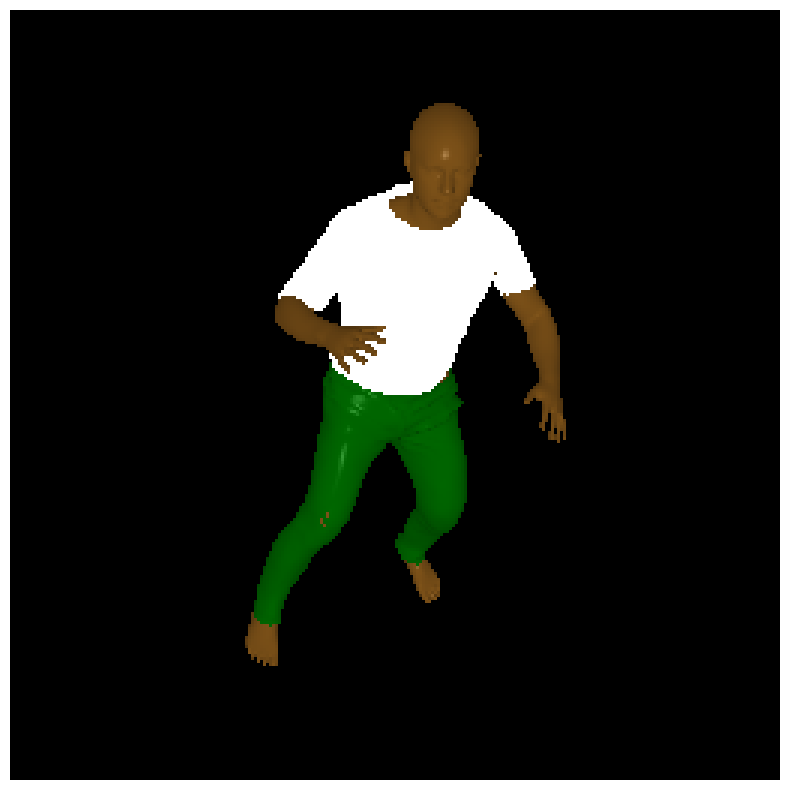

In [9]:
img = rgb

print(seg_maps[2].shape)
print(seg_maps.dtype)

img[seg_maps[0] == 1.] = 1.

plt.figure(figsize=(10, 10))
plt.imshow(img[..., :3])
plt.axis("off");